In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)  # Set for our testing purposes, please do not change!


class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)


z_dim = 64
image_size = 299
device = 'cpu'  # You're not training here, so do this on CPU

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

in_coursera = False  # Set this to false if you're running this outside Coursera
if in_coursera:
    import numpy as np

    data = torch.Tensor(np.load('fid_images_tensor.npz', allow_pickle=True)['arr_0'])
    dataset = torch.utils.data.TensorDataset(data, data)
else:
    dataset = CelebA("../data/", download=False, transform=transform)
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"../data/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

from torchvision.models import inception_v3

inception_model = inception_v3(pretrained=True)
# inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.load_state_dict(torch.load("../data/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval()

# Optional hint for inception_model.fc
inception_model.fc = torch.nn.Identity()

# UNIT TEST
test_identity_noise = torch.randn(100, 100) 
aa = inception_model.fc(test_identity_noise)

# assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
assert torch.equal(test_identity_noise, aa)
print("Success!")

Success!


/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/ax

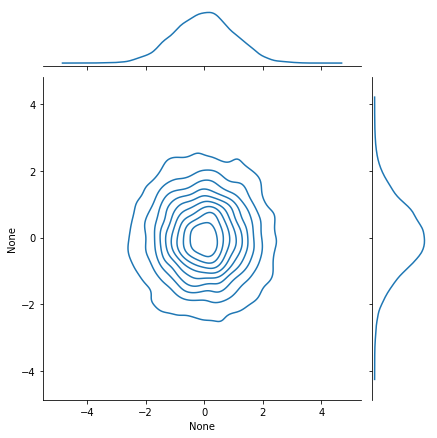

In [2]:
from torch.distributions import MultivariateNormal
import seaborn as sns  # This is for visualization

mean = torch.Tensor([0, 0])
covariance = torch.Tensor([
    [1, 0],
    [0, 1]
])
independent_dist = MultivariateNormal(mean, covariance_matrix=covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')
plt.show()


/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/dske/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/ax

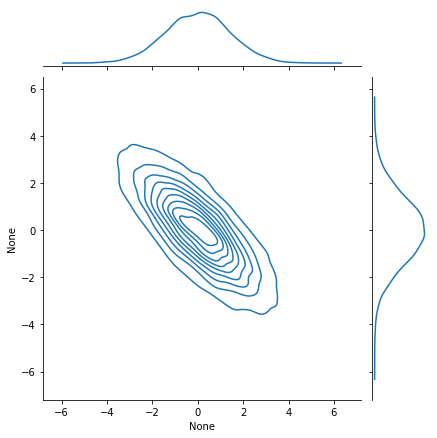

In [3]:
mean=torch.Tensor([0,0])
covariance = torch.Tensor([
    [2, -1.5],
    [-1.5, 2]
])
covariance_dist=MultivariateNormal(mean,covariance_matrix=covariance)
samples=covariance_dist.sample((10000,))
res=sns.jointplot(samples[:,0],samples[:,1],kind='kde')
plt.show()


In [4]:

import scipy


def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)


def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - \
           2 * torch.trace(matrix_sqrt(sigma_x @ sigma_y))


mean1 = torch.Tensor([0, 0])
covariance1 = torch.Tensor([
    [1, 0],
    [0, 1]
])
dist1 = MultivariateNormal(mean1, covariance1)
mean2 = torch.Tensor([0, 0])
covariance2 = torch.Tensor([
    [2, -1],
    [-1, 2]
])
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(
    frechet_distance(
        dist1.mean, dist2.mean,
        dist1.covariance_matrix, dist2.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

assert (
        frechet_distance(
            dist1.mean, dist1.mean,
            dist1.covariance_matrix, dist1.covariance_matrix
        ).item() == 0)
print('success')


success


In [5]:
def preprocess(img): 
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [6]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [7]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)
            fake_samples = get_noise(len(real_example), z_dim).to(device) 
            fake_samples = preprocess(gen(fake_samples)) 
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]

Success!
132.02622985839844


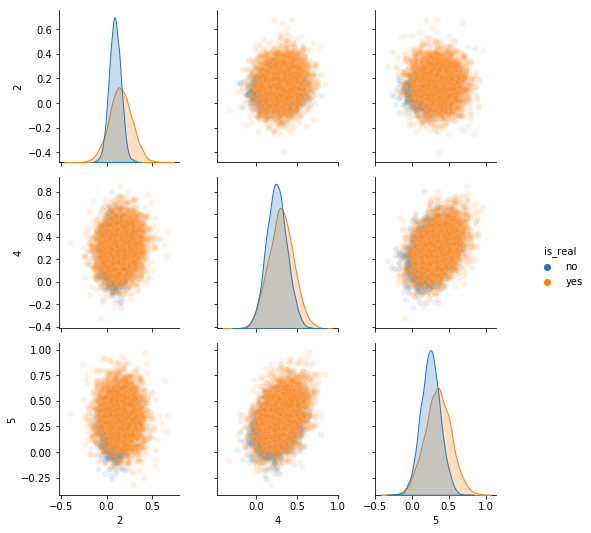

In [10]:

fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

#####
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

########
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
assert torch.abs(sigma_fake[0, 0] - 2.5e-2) < 1e-2 and torch.abs(sigma_fake[-1, -1] - 5e-2) < 1e-2
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
# assert torch.abs(sigma_real[0, 0] - 3.5768e-2) < 1e-4 and torch.abs(sigma_real[0, 1] + 5.3236e-4) < 1e-4
# assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
# assert tuple(mu_real.shape) == (real_features_all.shape[1],)
# assert torch.abs(mu_real[0] - 0.3099) < 0.01 and torch.abs(mu_real[1] - 0.2721) < 0.01
# assert torch.abs(mu_fake[0] - 0.37) < 0.05 and torch.abs(mu_real[1] - 0.27) < 0.05
print("Success!")

indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))
import pandas as pd

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake['is_real']='no'
df_real['is_real']='yes'
df=pd.concat([df_fake,df_real])

sns.pairplot(df,plot_kws={'alpha':0.1},hue='is_real')

with torch.no_grad():
    print(frechet_distance(mu_real,mu_fake,sigma_real,sigma_fake).item())